In [1]:
%load_ext autoreload
%autoreload 2

from text3d2video.artifacts.anim_artifact import AnimationArtifact

In [2]:
anim_tag = "mv_backpack:latest"
anim_tag = 'mv_helmet:latest'
anim_tag = "mv_cat_statue:latest"

texture_anim = AnimationArtifact.from_wandb_artifact_tag(anim_tag)
seq = texture_anim.read_anim_seq()

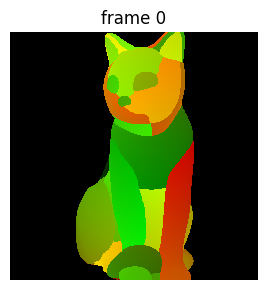

In [3]:
from text3d2video.rendering import render_rgb_uv_map
from text3d2video.utilities.ipython_utils import display_ims

frame_i = 0

mesh = seq.meshes[frame_i]
cam = seq.cams[frame_i]
verts_uvs = seq.verts_uvs
faces_uvs = seq.faces_uvs

display_ims(
    render_rgb_uv_map(mesh, cam, verts_uvs, faces_uvs), titles=[f"frame {frame_i}"]
)

In [4]:
from pytorch3d.structures import Meshes
import torch

verts_uvs_scaled = verts_uvs * 2 - 1
verts_uvs_xyz = torch.cat(
    [verts_uvs_scaled, torch.zeros_like(verts_uvs[:, :1])], dim=-1
)

uv_mesh = Meshes(verts=[verts_uvs_xyz], faces=[faces_uvs])

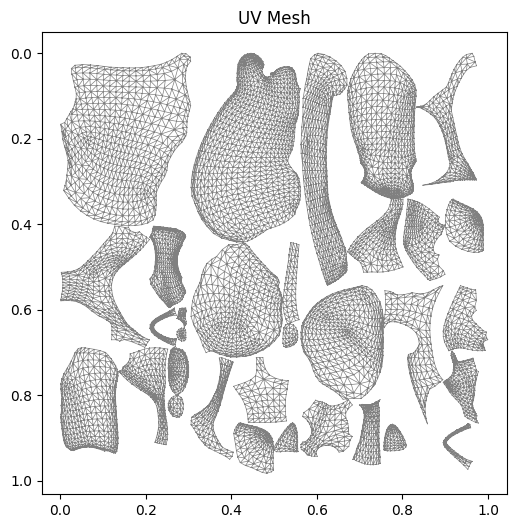

In [38]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

triang = mtri.Triangulation(
    x=verts_uvs[:, 0].cpu(), y=verts_uvs[:, 1].cpu(), triangles=faces_uvs.cpu()
)

plt.figure(figsize=(6, 6))
plt.triplot(triang, lw=0.5, color="gray")
plt.gca().invert_yaxis()  # Optional: match UV layout convention
plt.title("UV Mesh")
plt.axis("equal")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9994294].


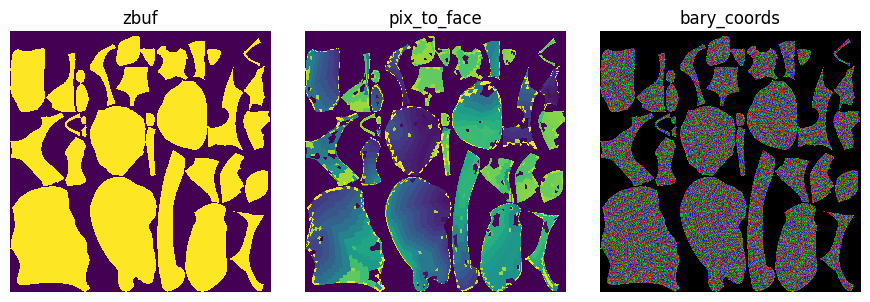

In [39]:
from pytorch3d.renderer import OrthographicCameras

from text3d2video.rendering import display_frags, make_mesh_rasterizer
from text3d2video.utilities.camera_placement import front_facing_extrinsics

R, T = front_facing_extrinsics(zs=1)
uv_camera = OrthographicCameras(R=R, T=T, device="cuda")

uv_res = 512
rasterizer = make_mesh_rasterizer(resolution=uv_res)
uv_frags = rasterizer(uv_mesh, cameras=uv_camera)

display_frags(uv_frags)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9994294].


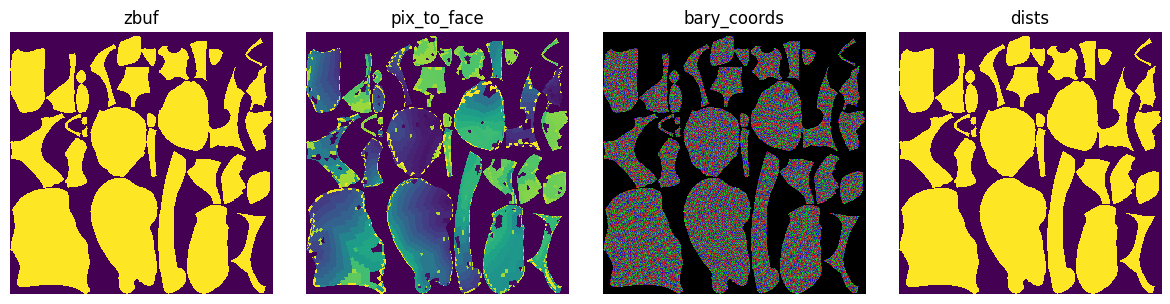

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9994294].


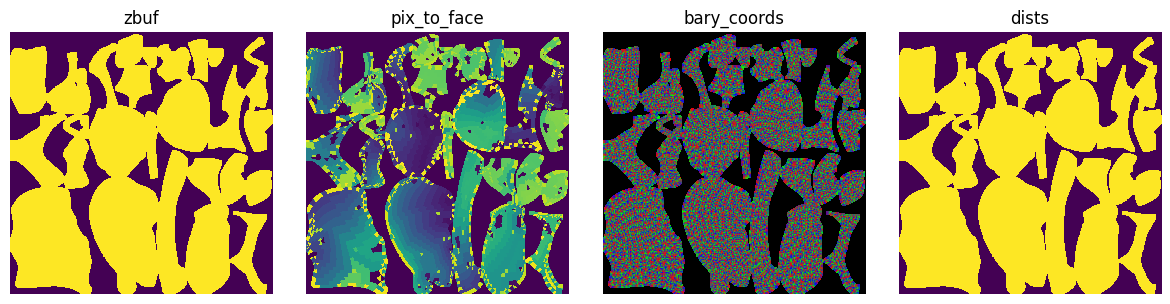

: 

In [150]:
from text3d2video.rendering import dilate_feature_map, dilate_frags

frags_dil = dilate_frags(uv_frags, iterations=3)

display_frags(uv_frags)
display_frags(frags_dil)

In [40]:
from rerun import Tensor
from torch import max_pool2d

from text3d2video.util import chw_to_hwc, hwc_to_chw

pix_to_face_og = uv_frags.pix_to_face[0, ..., 0]
bary_coords_og = uv_frags.bary_coords[0, :, :, 0, :]

valid_mask_og = pix_to_face_og != -1

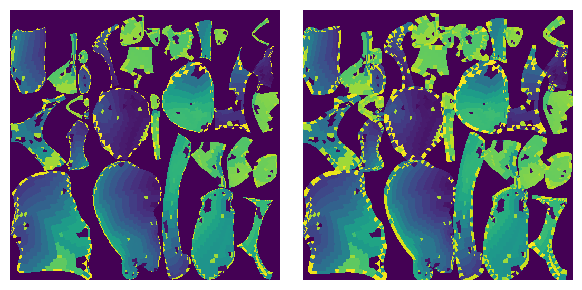

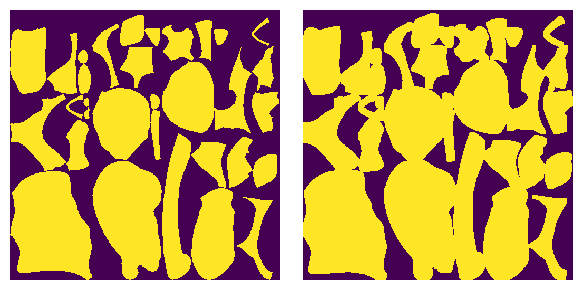

In [ ]:

feature_map = pix_to_face_og.unsqueeze(0).unsqueeze(0).float()
mask = valid_mask_og.unsqueeze(0).unsqueeze(0)

dilated, updated_mask = dilate_feature_map(feature_map, mask, iterations=3)

display_ims([feature_map[0, 0].cpu(), dilated[0, 0].cpu()])
display_ims([mask[0,0].cpu(), updated_mask[0,0].cpu()])

In [ ]:

def dilate(feature_map: Tensor, bg_mask: Tensor):
    pooled = max_pool2d(feature_map, kernel_size=3, stride=1, padding=1)
    dilated = feature_map.clone()
    dilated[:, bg_mask] = pooled[:, bg_mask]
    return dilated

pix_to_face = dilate(pix_to_face_og.unsqueeze(0).float(), ~valid_mask_og)[0].long()
bary_coords = chw_to_hwc(dilate(hwc_to_chw(bary_coords_og), ~valid_mask_og))

valid_mask = pix_to_face != -1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49999267..0.49869296].


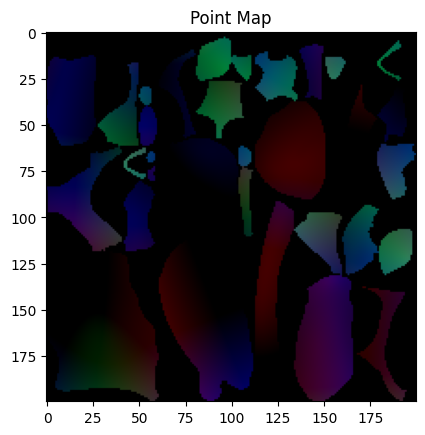

In [110]:
cam = seq.cams[0]

pix_to_face = uv_frags.pix_to_face[0, ..., 0]
bary_coords = uv_frags.bary_coords[0, :, :, 0, :]

faces = mesh.faces_list()[0]
verts = mesh.verts_list()[0]

# mask over UV space of valid texels
valid_mask = pix_to_face != -1

# for each valid texel, its face index and bary coords
texel_faces = pix_to_face[valid_mask]
texel_bary = bary_coords[valid_mask]

tri_inds = faces[texel_faces.cpu()]
v0, v1, v2 = verts[tri_inds[:, 0]], verts[tri_inds[:, 1]], verts[tri_inds[:, 2]]

pts = texel_bary[:, 0:1] * v0 + texel_bary[:, 1:2] * v1 + texel_bary[:, 2:3] * v2

# place points on map
H, W = pix_to_face.shape
point_map = torch.zeros((H, W, 3)).to(pix_to_face.device)
point_map[valid_mask] = pts

plt.title("Point Map")
plt.imshow(point_map.cpu())

(-0.512700779736042,
 0.527846647799015,
 -1.1627124786376952,
 1.1542331218719482)

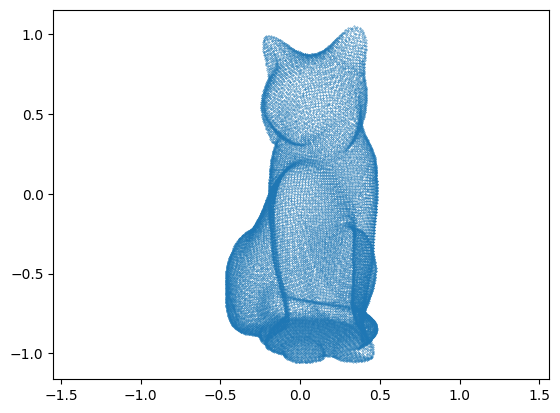

In [112]:
points_flat = point_map[valid_mask]  # (N, 3)

ndc_coords = cam.transform_points_ndc(points_flat)  # (N, 3)
ndc_coords[:, 0] = -ndc_coords[:, 0]  # flip y axis

plt.scatter(ndc_coords[:, 0].cpu(), ndc_coords[:, 1].cpu(), s=0.1)
# plt.scatter(screen_coords[:, 0].cpu(), screen_coords[:, 1].cpu(), s=0.1)
plt.axis("equal")

In [113]:
points_cam = cam.get_world_to_view_transform().transform_points(points_flat)  
points_zs = points_cam[:, 2]  # (N, 3)

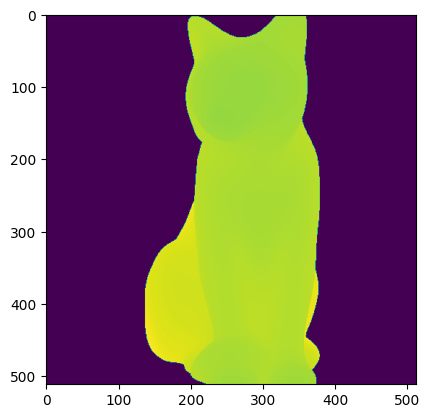

In [115]:


depth_rasterizer = make_mesh_rasterizer(resolution=512)
view_frags = depth_rasterizer(mesh, cameras=cam)
zbuf = view_frags.zbuf[0, ..., 0]

plt.imshow(zbuf.cpu())

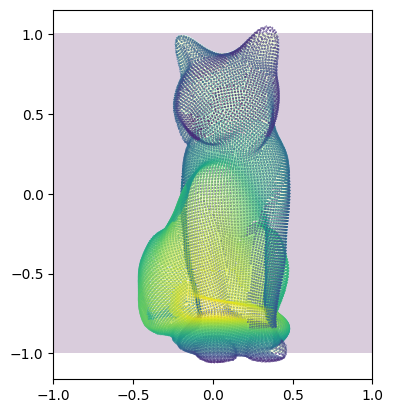

In [116]:
ndc_coords_xy = ndc_coords[:, :2]

plt.imshow(zbuf.cpu(), extent=(-1, 1, -1, 1), alpha=0.2)
plt.scatter(
    ndc_coords[:, 0].cpu(),
    ndc_coords[:, 1].cpu(),
    s=0.1,
    c=ndc_coords[:, 2].cpu(),
)

(tensor(-1., device='cuda:0'), tensor(2.6253, device='cuda:0'))

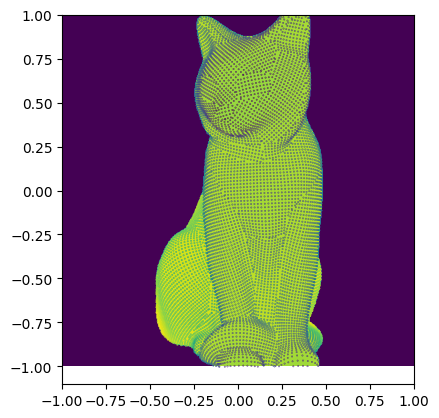

In [117]:
from text3d2video.util import sample_feature_map_ndc


texel_true_depth = sample_feature_map_ndc(zbuf.unsqueeze(0), ndc_coords_xy)[:, 0]

eps = 0.01
visible_mask = points_zs < texel_true_depth + eps
visible_xys = ndc_coords_xy[visible_mask]

plt.imshow(zbuf.cpu(), extent=(-1, 1, -1, 1), alpha=1)
plt.scatter(
    visible_xys[:, 0].cpu(),
    visible_xys[:, 1].cpu(),
    s=0.1,
    c=points_zs[visible_mask].cpu(),
)


# texel_zs.min(), texel_zs.max()
points_zs.min(), points_zs.max()
texel_true_depth.min(), texel_true_depth.max()


# Final Call to function

In [118]:
from text3d2video.backprojection import compute_texel_projection_old, compute_texel_projection, display_projection


projection = compute_texel_projection_old(mesh, cam, verts_uvs, faces_uvs, 300)
projection_new = compute_texel_projection(mesh, cam, verts_uvs, faces_uvs, 300)

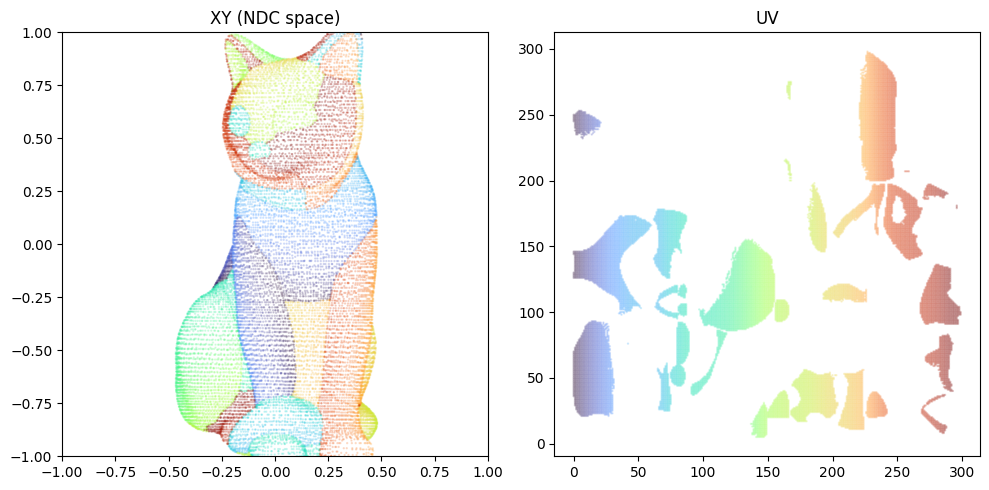

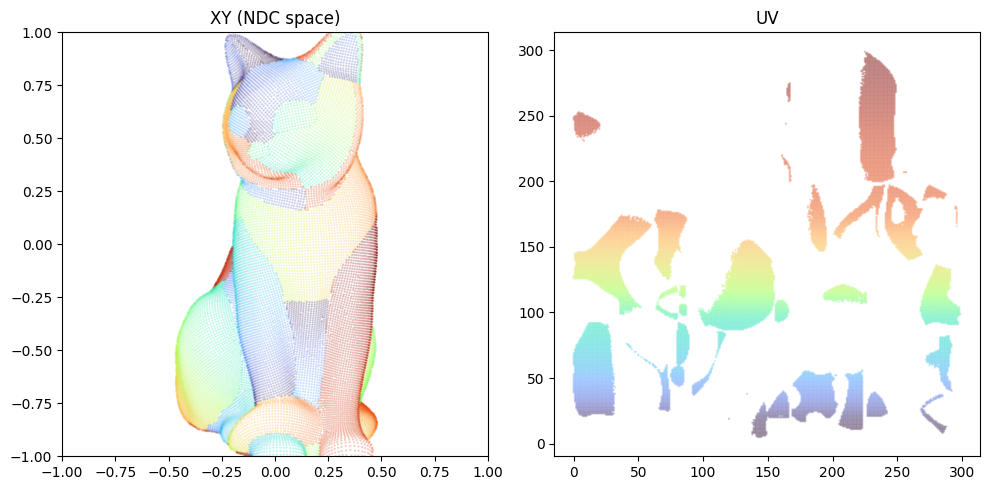

In [119]:
display_projection(projection)
display_projection(projection_new)